# Нейронная сеть экстренных вызовов

In [1]:
#@title Загрузка импортов
import tensorflow
import os # работа с папками и файлами
import librosa # параметризация аудио
import librosa.display
import numpy as np # математические формулы
import noisereduce as nr
import matplotlib.pyplot as plt # отображение графиков
import seaborn as sns # график матрицы ошибок
import soundfile as sf # загрузка и сохранение аудиофайла
import pandas as pd
import joblib # сохранение/загрузка StandardScaler

from tensorflow.keras.backend import clear_session # очистка памяти от прошлой архитектуры
from tensorflow.keras import layers # базовые слои
from tensorflow.keras import optimizers # подключаем оптимизаторы
from tensorflow.keras.models import Sequential, Model # модели keras
from tensorflow.keras.utils import to_categorical # для представления в формате one_hot_encoding
from tensorflow.math import confusion_matrix # матрица ошибок
from sklearn.metrics import confusion_matrix as _cx
from sklearn.metrics import precision_score, recall_score # метрики для теста
from sklearn.preprocessing import StandardScaler # для нормировки данных
from scipy import signal # увеличение громкости
from scipy.signal import butter, lfilter, medfilt # фильтры низких частот
from IPython.display import Audio # проигрывание аудио
# импортируем коллбэки
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
#@title Параметры датасета
#@markdown Название корневой папки при работе google диском.
main_dir = 'dataset_revshift' #@param {type:"string"}

# Использую try, except что бы обучать в колабе и юпитере
try:
    from google.colab import files # загрузка файлов с гугл диска
    from google.colab import drive #подключаем библиотеку для работы с google диском
    drive.mount('/content/drive') #монтируем google диск
    main_dir = f'/content/drive/MyDrive/{main_dir}/'
    %cd {main_dir}
except: None

# Веса модели для цикла обучений
wts = "emergency_calls_net_weights.h5"
# Тадлица распределения сигналов
# Тадлица распределения сигналов
data = pd.read_csv('revshift.csv')
cls_3group = {}
cls_3group['Истина_посторонние_звуки']=1
cls_3group['Ложь_посторонние_звуки']=0
cls_3group['Истина_тишина']=1
cls_3group['Ложь_тишин']=0
cls_3group['true']=1
cls_3group['false']=0
cls_3group['Истина_разговоры']=1
cls_3group['Ложь_разговоры']=0

correct_cls = lambda x: cls_3group[x]
# получаем истинный класс из пути к файлу
get_cls_from_name = lambda x: correct_cls(x.split('\\')[-2])
data['cls'] = data['original_path'].apply(get_cls_from_name)
# Загрузка scaler из файла, если он есть
#scaler_path = 'scaler_3.save'
# длинна сегмента сигнала в секундах
sec = 6

# data.query("original_dir_cls in ['false', 'true']")
# data.query("original_dir_cls in ['Истина_посторонние_звуки', 'Ложь_посторонние_звуки']")
# data.query("original_dir_cls in ['Истина_разговоры', 'Ложь_разговоры']")
# data.query("original_dir_cls in ['Истина_тишина', 'Ложь_тишин']")


In [3]:
#@title Информация по таблице распределений сигналов
def items(data):
    def items(data, cls, sample):
        items = lambda data, cls, sample: data.query(f'cls == {cls} and sample == "{sample}"')['duration']
        s = items(data, cls, sample)
        # str: sample files count
        result = sample + ': ' + str(len(s)) + ' files. '
        # str: sample duration
        result_2 = str(sum(s)) + ' sec. '
        # str: Average duration for sample
        result_3 = 'Average: ' + str(np.median(s)) + ' sec.'
        return print(result + result_2 + result_3)
    for cls in [0, 1]:
        if cls==0: head = '\nfalse '
        else: head = '\n\ntrue '
        print(head, len(data.query(f'cls == {cls}')))
        for sample in ["train", "val", "test"]:
            items(data, cls, sample)

items(data)



false  3464
train: 2511 files. 10971 sec. Average: 6.0 sec.
val: 864 files. 4043 sec. Average: 6.0 sec.
test: 89 files. 536 sec. Average: 6.0 sec.


true  3793
train: 2652 files. 15912 sec. Average: 6.0 sec.
val: 1023 files. 6138 sec. Average: 6.0 sec.
test: 118 files. 709 sec. Average: 6.0 sec.


In [4]:
#@title Функция параметризации аудио
# Новый набор признаков. Бинарный
def get_features(y, sr, binary_out=False):
    
    #Получаем различные параметры аудио
    rmse = librosa.feature.rms(y=y) # Среднеквадратичная амплитуда
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr) # Cреднее спектрального спада частоты
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) # Частота цветности (по умолчанию 12 баков цветности)
    
    # конвертация значения в бинарный вариант по среднему значению и смещению k
    set_binary = lambda x, mean, k=1.0: 1 if x < mean*k else 0
    r_set_binary = lambda x, mean, k=1.0: 1 if x > mean*k else 0
    
    #Добавляем все параметры в один список
    out = [] # создаем пустой список
    # добавляем среднеквадратичную амплитуду
    # 0
    if binary_out: out.append(set_binary(np.median(rmse), 0.059449, .5))
    else: out.append(np.median(rmse)) 
    # добавляем спектральный спад частоты
    # 1
    if binary_out: out.append(set_binary(np.min(rolloff), 617.939479, .8))
    else: out.append(np.min(rolloff)) 
    # добавляем среднее всех Частот цветности
    # 2
    chroma_stft = np.min(list(map(np.min, chroma_stft)))
    if binary_out: out.append(set_binary(chroma_stft, 0.003046, .02))
    else: out.append(chroma_stft) 
    # возвращаем получившийся список размерностью (3,)
    return out


In [5]:
#@title Функция aугментации
# Генератор списка аугментаций к сегменту сигнала в зависимости от его длины
aug_gen = (lambda text='': 'augs-- gen' + text
           + np.random.choice(['', ' white_noise', ' mx2y', 
                               ' mxy', ' low_hz', ' avg', 
                               ' slow_down', ' echo', ' relu', 
                               ' mn2y', ' mny', ' reverse', 
                               ' stft', ' noised_echo', ' high_hz', 
                               ' pink_noise']))
######################################
#aug_gen = (lambda text='': 'augs-- ' + text)
#data = data.assign(count=1)
##################

comment = lambda x: aug_gen(" repeat") if x < sec else aug_gen()
# Пример comment(len(y)/sr) --> "augs-- gen white_noise"

# изменнный сигнал
def augmentation(y, sr=22050, augs='augs-- '):

    # частота колебаний в секунду
    def get_frequency(y, sr):
        # выбираем участок сигнала длительностью 1 секунду
        y_1sec = y[:sr]
        # определяем точки пересечения нулевой линии
        zero_crossings = np.where(np.diff(np.sign(y_1sec)) != 0)[0]
        # подсчитываем количество точек пересечения
        num_zero_crossings = len(zero_crossings)
        # вычисляем частоту
        frequency = num_zero_crossings / 1  # 1 секунда
        return frequency

    # переменные для aug
    mx2 = max(y)/2
    mn2 = min(y)/2
    mx = max(y)
    mn = min(y)
    mean = np.mean(y)
    f = get_frequency(y, sr)
    original_y = y

    # генератор меняет базовые значения параметра x на 0-3%
    # что бы сигналы имели больше отличий между собой
    gen = lambda y, sr: (np.random.choice((np.arange(97,103,1)/100))*y, sr)

    # повторить сигнал 3 раза
    repeat = lambda y, sr: (np.concatenate(([y]*3)), sr)

    # добавление белого шума к аудио сигналу. strength - сила белого шума
    noise_white = lambda y, sr, strength=0.01: (y + (strength * np.random.randn(len(y))), sr)

    # модификация. принцип активатора relu
    relu = lambda y, sr: (np.array(list(map(lambda x: 0 if x<0 else x, y)), dtype=np.float32), sr)
    # модификация mn2y. стандартизация минимальных значений сигнала к среднему в диапозоне значений y
    mn2y = lambda y, sr: (np.array(list(map(lambda x: mn2 if x<mn2 else x, y)), dtype=np.float32), sr)
    # модификация mny. стандартизация минимальных значений сигнала к минимуму в диапозоне значений y
    mny = lambda y, sr: (np.array(list(map(lambda x: mn if x<0 else x, y)), dtype=np.float32), sr)

    # модификация mx2y. стандартизация максимальных значений сигнала к среднему в диапозоне значений y
    mx2y = lambda y, sr: (np.array(list(map(lambda x: mx2 if x>mx2 else x, y)), dtype=np.float32), sr)
    # модификация mxy. стандартизация максимальных значений сигнала к максимуму в диапозоне значений y
    mxy = lambda y, sr: (np.array(list(map(lambda x: mx if x>0 else x, y)), dtype=np.float32), sr)

    # модификация avg. сокращение диапозона значений
    avg = lambda y, sr: (np.array(list(map(lambda x: mean if x<mn2 or x>mx2 else x, y)), dtype=np.float32), sr)

    # уменьшение скороти (частоты дискретизации) в два раза
    slow_down = lambda y, sr: (y, 11025)

    # искуственое отставание сигнала на shift значений
    shifted_y = lambda y, shift=1500: np.concatenate([np.concatenate(([y[:1]]*shift)), y])[:-shift]
    # ревербирация сигнала. эхо
    echo = lambda y, sr: (shifted_y(y)+y, sr)
    # ревербирация сигнала. аугментация + оригинал + эхо
    noised_echo = lambda y, sr: (shifted_y(y)+original_y if len(shifted_y(y))==len(original_y) else echo(y, sr)[0], sr)

    # реверсировать аудио
    reverse = lambda y, sr: (y[::-1], sr)

    # добавление шума к аудио сигналу
    def noise_pink(y, sr):
        # выбираем участок сигнала длительностью 1 секунду
        y_1sec = y[:sr]
        # определяем точки пересечения нулевой линии
        zero_crossings = np.where(np.diff(np.sign(y_1sec)) != 0)[0]
        # подсчитываем количество точек пересечения
        num_zero_crossings = len(zero_crossings)
        if num_zero_crossings == 0:
            return y, sr  # Не добавляем шум, если нет нулевых переходов
        # вычисляем частоту
        frequency = num_zero_crossings / 1  # 1 секунда
        return y + (1 / frequency**2), sr
    
    # Применение фильтра для выделения высокочастотных компонентов в сигнале
    get_high_hz = lambda y, sr: (librosa.effects.preemphasis(y), sr)

    # Определение фильтра нижних частот
    def butter_lowpass(cutoff_freq, sr, order=5):
        nyquist = 0.5 * sr
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a
    def apply_lowpass_filter(data, cutoff_freq, sr, order=5):
        b, a = butter_lowpass(cutoff_freq, sr, order=order)
        y = lfilter(b, a, data)
        return y
    # Установка частоты среза для фильтра нижних частот
    cutoff_freq = 1000 # Регулировка по мере необходимости
    # Применение фильтра нижних частот к аудиосигналу
    get_low_hz = lambda y, sr: (apply_lowpass_filter(y, cutoff_freq, sr), sr)

    # Применение медианного фильтра к аудиосигналу
    window_size = 5 # Регулировка по мере необходимости
    get_median_signal = lambda y, sr: (medfilt(y, kernel_size=window_size), sr)

    # Вычисление кратковременного преобразования Фурье (STFT)
    def get_stft(y, sr):
        stft = librosa.stft(y=y, n_fft=2048)
        # Вычисление спектрограммы амплитуд
        magnitude_spectrogram = np.abs(stft)
        # Инициализация фонового и шумового спектра
        background = np.random.rand(*magnitude_spectrogram.shape)
        foreground = np.random.rand(*magnitude_spectrogram.shape)
        # Итеративное обновление фонового и шумового спектра
        for i in range(100):
            background = np.minimum(magnitude_spectrogram, foreground)
            foreground = np.maximum(0, magnitude_spectrogram - background)
        # Вычисление маски шума
        noise_mask = np.abs(background)
        # Вычисление деноизированного аудио
        # Добавление малой константы к знаменателю для избежания деления на ноль
        epsilon = 1e-10
        l_istft = librosa.istft(foreground * noise_mask / (np.abs(noise_mask) + epsilon))
        denoised_audio = y[:len(librosa.istft(foreground))] - l_istft
        return y, sr

    mods = {'gen': gen, 
            'white_noise': noise_white,
            'relu': relu,
            'mn2y': mn2y,
            'mny': mny,
            'mx2y': mx2y,
            'mxy': mxy,
            'avg': avg,
            'slow_down': slow_down,
            'echo': echo,
            'noised_echo': noised_echo,
            'reverse': reverse,
            'pink_noise': noise_pink,
            'repeat': repeat,
            'high_hz': get_high_hz, 
            'low_h': get_low_hz, 
            'median_signal': get_median_signal, 
            'stft': get_stft
           }

    for mod in augs.split(' '):
        if mod in mods.keys():
            y, sr = mods[mod](y, sr)
    return y, sr

In [6]:
#@title Функция создания выборки из папки с файлами
# Этот блок кода ожидает файлы: revshift.csv, scaler.save (опционально).
# Так же директории с датасетами: calls, CallsDataset

# функция получает адреса и всю инофрмацию о сигналах в таблице
# извлекает сигнал --> разрезает на сегменты --> наносит фильтры на сегмент
# параметризирует сегмент --> сохраняет в выборке в форме списка
# все списки X, y загружаются в словарь
def get_sample(sample_name, aug=True, k=1, data=data, q=''):
    # группируем таблицу по имени сигнала и номеру сегмента в нем
    # что бы избежать лишних потвторов и сократить объем работы
    data = data.query(f'sample == "{sample_name}" {q}')
    cols = ['label', 'segment_number']
    data = data.drop_duplicates(cols)
    data = data.sort_values(cols).reset_index(drop=True)

    # cоздаём пустые массивы выборки
    X, Y = [], []

    for i in range(len(data)):
        # извлекаем информацию о сегменте
        segment = data.loc[i]

        # процесс librosa.load занимает много времени, его можно и нужно избегать.
        # извлекаем значения сигнала, если прошлый путь к сигналу был другим
        try:
            # проверим существование переменных
            y, sr
            # выгружаем y, sr если действующий original_path не совпадает с прошлым
            if segment['original_path'] != data.loc[i-1,'original_path']:
                y, sr = librosa.load(segment['original_path'])
        # try вызвал ошибку - значит выгрузка y, sr необходима.
        except: 
            y, sr = librosa.load(segment['original_path'])

        # вырезаем сегмент
        segment_y, segment_sr = y[sr*segment['start_sec']:sr*segment['stop_sec']], sr
        for count in range(segment['count']*k):
            _y, _sr = segment_y, segment_sr
            if count > 0 and aug:
                # аугментирование сигнала, если есть повторы сегмента
                _y, _sr = augmentation(segment_y, segment_sr, comment(segment['duration']))
            # параметризация сигнала. запись в выборку
            X.append(get_features(_y, _sr))
            Y.append(segment['cls'])
    
    return np.array(X, dtype=np.int64), np.array(Y, dtype=np.int64)

# Преобразуем массивы в numpy
#X_train, Y_train = get_sample(sample_name= "train", aug=True, k=1)
#X_val, Y_val  = get_sample(sample_name = "val", aug=True, k=1)


In [7]:
#@title Функции визуализации результата
def accuracy_graph(result):
    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('График процесса обучения модели')

    ax1.set_title(f'Accuracy')
    ax1.plot(result.history['binary_accuracy'],
                   label='Доля верных ответов на обучающем наборе')
    ax1.plot(result.history['val_binary_accuracy'],
                   label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.set_title(f'Loss')
    ax2.plot(result.history['loss'],
                   label='Ошибка на обучающем наборе')
    ax2.plot(result.history['val_loss'],
                   label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# model.save('model.h5', include_optimizer=False)

# визуализируем матрицы ошибок
def get_confusion_matrix(y_pred, y_test, title='Тест'):
    # Получаем истинные метки
    y_true = y_test

    # проверим модель на эффективность. Выводим матрицу ошибок
    recall = ("recall: %.2f" % recall_score(y_true, y_pred))
    precision = ("precision: %.2f" % precision_score(y_true, y_pred))

    # Создаем фигуру с двумя подграфиками, расположенными рядом
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Строим вторую тепловую карту на втором подграфике
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
    axes[0].set_title(f'{title}. {recall}, {precision}')

    # Строим первую тепловую карту на первом подграфике
    cm = _cx(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, ax=axes[1])
    axes[1].set_title('Соотношение в процентах. Итоговая точность: {0}'.format(round((cm[0][0]+cm[1][1])/2, 2)))

    plt.show()
    
# Код теста
def test_sample(network_model, test_aug=False, data=data):
    
    # Конвертация числа в текст
    string_cls = lambda x: 'Авария' if x==1 else 'Ложный вызов'

    def prediction(signal, network_model, aug=False):
        #Получаем аудио сигнал
        y, sr = librosa.load(signal, duration=sec)
        duration = int(len(y)/sr)
        if aug: y, sr = augmentation(y, sr, comment(int(len(y)/sr)))
        #Параметризуем сигнал
        out = get_features(y, sr)
        #Добавляем ону размерность, этого требует model.predict
        out = np.array(out).reshape(1,len(indexes))
        # округление результата
        round_result = lambda y: 1 if y >= 0.5 else 0
        #Делаем predict
        y_pred = network_model.predict(out, verbose=0)
        y_pred = np.argmax(y_pred)
        # получаем истинный класс из пути к файлу
        y = get_cls_from_name(signal)
        return signal, duration, y, y_pred

    dt = {}
    dt['Сигнал'] = []
    dt['Продолжительность (сек.)'] = []
    dt['Правильный_класс'] = []
    dt['Распознанный_класс'] = []
    dt['Совпадение'] = []

    for f in np.unique(data.query('sample == "test"')['original_path']):
        p = prediction(f, network_model, aug=test_aug)
        dt['Сигнал'].append(p[0])
        dt['Продолжительность (сек.)'].append(p[1])
        dt['Правильный_класс'].append(p[2])
        dt['Распознанный_класс'].append(p[3])
        dt['Совпадение'].append(p[2]==p[3])
    
    print('\n')
    dt = pd.DataFrame(dt).assign(Сигнал=list(map(lambda x: '\\'.join(x.split('\\')[-2:]), dt['Сигнал'])))
    display(dt)
    # визуализируем матрицы ошибок
    base_cls = list(map(lambda x: True if x.split('\\')[-1].lower()[0]=='t' else False, dt['Сигнал']))
    get_confusion_matrix(dt['Распознанный_класс'], base_cls, title='Тестовая выборка')
    

In [8]:
#@title Архитектура
# Чистим оперативную память
clear_session()
# Указываем, какие индексы данных во входных векторах брать для обучения
# Делаем это для того, чтобы можно было экспериментировать
# И обучать не на всех колонках данных, а на части
indexes = range(0,3)

inputs = layers.Input(shape=(len(indexes)))

x = layers.Dense(256)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Activation("tanh")(x)

x = layers.Dense(1)(x)
outputs = layers.Activation('sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

#Компилируем сеть
model.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# Создаем коллбек сохранения весов
checkpoint = ModelCheckpoint(wts, save_weights_only=True, save_best_only=True)
# EarlyStopping останавливает процесс обучения, если качество модели на проверочных данных 
# перестает улучшаться, что помогает избежать переобучения.
earlystop = EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)
# ReduceLROnPlateau динамически изменяет скорость обучения в зависимости от 
# изменения качества модели на проверочных данных. 
# Если качество модели на проверочных данных не улучшается в течение заданного числа эпох, 
# скорость обучения уменьшается на заданный коэффициент.
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 256)               1024      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                            

Epoch 1/100


21/21 [==============================] - 1s 11ms/step - loss: 1.3432 - binary_accuracy: 0.3144 - val_loss: 1.3398 - val_binary_accuracy: 0.5310 - lr: 1.0000e-06
Epoch 2/100
21/21 [==============================] - 0s 8ms/step - loss: 1.3430 - binary_accuracy: 0.3151 - val_loss: 1.2601 - val_binary_accuracy: 0.5167 - lr: 1.0000e-06
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 1.3482 - binary_accuracy: 0.3144 - val_loss: 1.2442 - val_binary_accuracy: 0.4822 - lr: 1.0000e-06
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 1.3418 - binary_accuracy: 0.3140 - val_loss: 1.2589 - val_binary_accuracy: 0.3095 - lr: 1.0000e-06
Epoch 5/100
21/21 [==============================] - ETA: 0s - loss: 1.3392 - binary_accuracy: 0.3122
Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.
21/21 [==============================] - 0s 4ms/step - loss: 1.3392 - binary_accuracy: 0.3122 - val_loss: 1.2801 - val_binary_accur

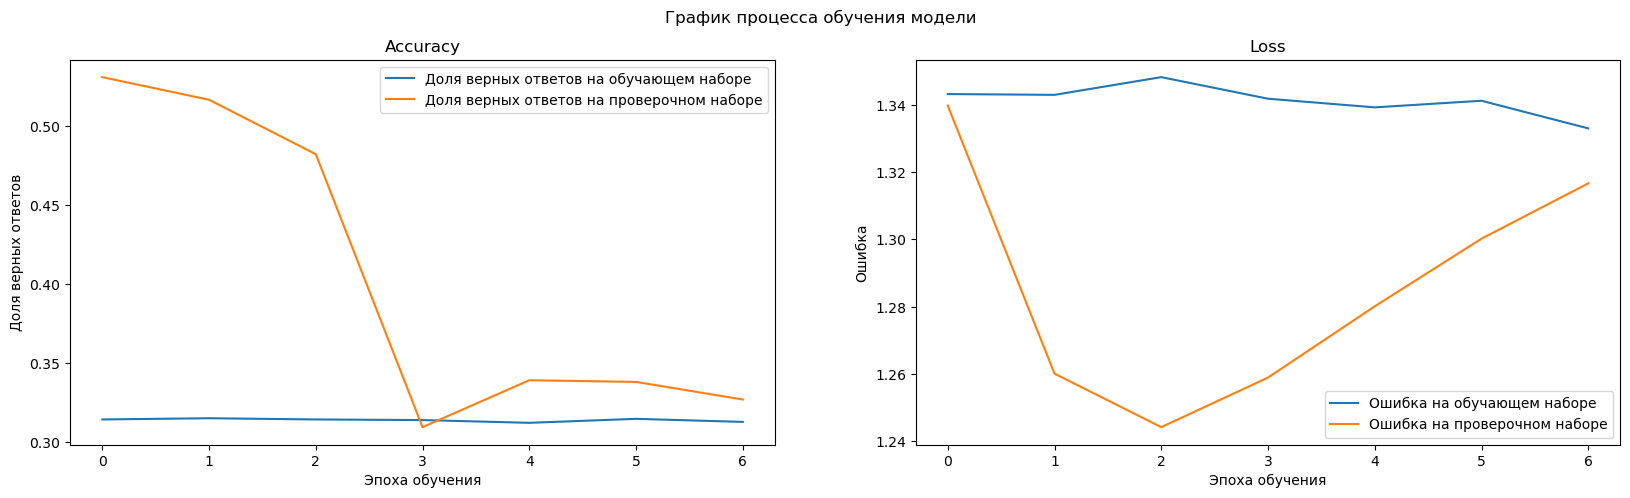

,Сигнал,Продолжительность (сек.),Правильный_класс,Распознанный_класс,Совпадение
0,Истина_посторонние_звуки\TrueSounds (12).mp3,6,1,0,False
1,Истина_посторонние_звуки\TrueSounds (121).mp3,6,1,0,False
2,Истина_посторонние_звуки\TrueSounds (31).mp3,6,1,0,False
3,Истина_посторонние_звуки\TrueSounds (39).mp3,6,1,0,False
4,Истина_посторонние_звуки\TrueSounds (59).mp3,6,1,0,False
5,Истина_посторонние_звуки\TrueSounds (88).mp3,6,1,0,False
6,Истина_посторонние_звуки\TrueSounds (9).mp3,6,1,0,False
7,Истина_разговоры\TrueSpeech (100).mp3,6,1,0,False
8,Истина_разговоры\TrueSpeech (117).mp3,6,1,0,False
9,Истина_разговоры\TrueSpeech (121).mp3,6,1,0,False


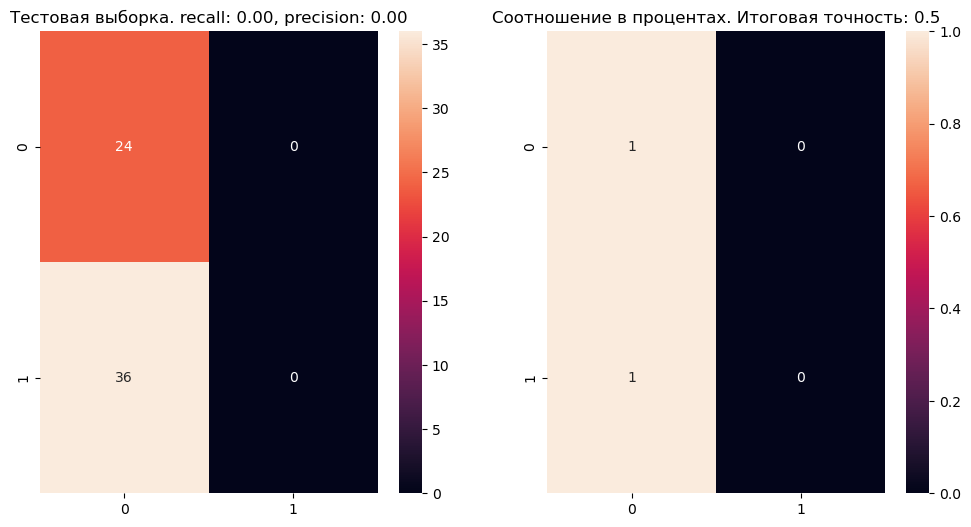

CPU times: total: 11min 57s
Wall time: 3min 53s


In [9]:
%%time
#@title Обучение модели
#@markdown aug - генерирует аугментации (рекомендуется). Соотношение классов без аугментаций: true > false.
train_aug = False #@param {type:"boolean"}
val_aug = False #@param {type:"boolean"}
test_aug = False
#@markdown k_aug - дополнительный множитель числа аугментаций (опционально).
train_k_aug = 1 #@param {type:"string"}
val_k_aug = 1 #@param {type:"string"}
#@markdown repeat - число повторов обучения
repeat = 1

# Цикл обучения
for i in range(repeat):
    # Генерация тренировочной и тестовой выборок
    # Используем те же переменные, если в пересоздании нет необходимости.
    if train_aug == False:
        try: X_train
        except: X_train, y_train = get_sample(sample_name="train", aug=False, k=1)
    elif train_aug: 
        X_train, y_train = get_sample(sample_name="train", aug=train_aug, k=train_k_aug)
    if val_aug == False:
        try: X_val
        except: X_val, y_val = get_sample(sample_name="val", aug=False, k=1)
    elif val_aug:
        X_val, y_val  = get_sample(sample_name="val", aug=val_aug, k=val_k_aug)
    
    # Загружаем веса модели из файла, если они есть
    if os.path.isfile(wts): model.load_weights(wts)
    #Обучаем
    history = model.fit(X_train[:, indexes], y_train,
                        epochs=100,
                        batch_size=250,
                        callbacks=[earlystop, 
                                   #checkpoint,
                                   reduceLROnPlateau],
                        shuffle=True,
                        validation_data=(X_val[:, indexes], y_val))
    
    if train_aug: del X_train, y_train, 
    if val_aug: del X_val, y_val
    
    # Вывод графиков точности и ошибки
    accuracy_graph(history)
test_sample(model, test_aug)
    
#model.save('model.h5', include_optimizer=False)
